In [1]:
# make imports from pa_lib possible (parent directory of file's directory)
import sys
from pathlib import Path

file_dir = Path.cwd()
parent_dir = file_dir.parent
sys.path.append(str(parent_dir))

%load_ext autoreload
%autoreload

import pandas as pd
import numpy as np
import altair as alt

from collections import namedtuple

from pa_lib.file import (
    project_dir,
    load_bin,
    store_bin,
)

# display long columns completely, show more rows
pd.set_option("display.max_colwidth", 300)
pd.set_option("display.max_rows", 200)
pd.set_option("display.max_columns", 200)

# Load data

In [2]:
with project_dir("axinova"):
    ax_data = load_bin("ax_data.feather")
    ax_var_struct = load_bin("ax_var_struct.feather")

Variable = namedtuple("Variable", ["Label", "Codes", "Order"])

var_info = {}
for var, data in ax_var_struct.groupby("Variable"):
    var_info[var] = Variable(
        data["Variable_Label"].max(),
        data["Label"].to_list(),
        data["Label_Nr"].to_list(),
    )

15:25:18 [INFO] Started loading binary file ...
15:25:18 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_data.feather
15:25:19 [INFO] ... finished loading binary file in 0.44s (1.41s CPU)
15:25:19 [INFO] Started loading binary file ...
15:25:19 [INFO] Reading from file C:\Users\kpf\data\axinova\ax_var_struct.feather
15:25:19 [INFO] ... finished loading binary file in 0.0s (0.0s CPU)


# Summarize per Year / Month

In [3]:
ax_data.columns

Index(['Station', 'DayOfWeek', 'Time', 'Variable', 'Code', 'Value', 'Year',
       'Month', 'logValue', 'VarDesc', 'TimeSlot', 'ShortTime', 'Hour',
       'is_weekend', 'is_day', 'is_rush', 'is_day_no_rush', 'TimeSlot_cat',
       'StationSprache'],
      dtype='object')

In [4]:
ax_data.loc[:, "YearMonth"] = ax_data["Year"].astype("str").str.cat(ax_data["Month"], sep=".")

In [17]:
ax_months = ax_data.groupby(["YearMonth", "Station"], observed=True, as_index=False)["Value"].agg("sum")

## Correct for changing panel size

In [18]:
panel_size = {
    "2019.05": 1980,
    "2019.06": 1991,
    "2019.07": 1975,
    "2019.08": 2025,
    "2019.09": 1936,
    "2019.10": 1935,
    "2019.11": 1938,
    "2019.12": 2218,
    "2020.01": 3039,
    "2020.02": 3069,
}

In [19]:
# Scale all months to a panel size of 2000
for month, size in panel_size.items():
    ax_months.loc[ax_months["YearMonth"] == month, "Value"] *= (2000 / panel_size[month])

In [20]:
ax_month_table = ax_months.pivot_table(values="Value", index="Station", columns="YearMonth").fillna(0).round(0).astype("int")

ax_month_table

YearMonth,2019.05,2019.06,2019.07,2019.08,2019.09,2019.10,2019.11,2019.12,2020.01,2020.02
Station,,,,,,,,,,
Aarau,136013,134825,104607,119895,129874,121120,118078,93602,105152,120005
Basel SBB,199353,181986,168060,180375,216389,202165,210597,188709,162059,161039
Bellinzona,34645,35747,46461,33993,36074,40490,28931,29515,24762,33958
Bern,541136,344326,355315,359135,380102,388117,388270,325601,271793,308105
Biel/Bienne,131282,116941,111797,124152,123531,100344,121308,99065,67173,81789
Brig,26010,27369,32817,35154,26695,23918,28054,31748,29544,44948
Chur,49494,40824,32115,38985,37769,30215,31171,38207,45483,53289
Fribourg,159315,120269,120406,96882,152840,143818,161161,143237,96632,120506
Genève Aéroport,58313,25311,67573,52543,55237,50889,36190,28392,29434,33888


# Graph

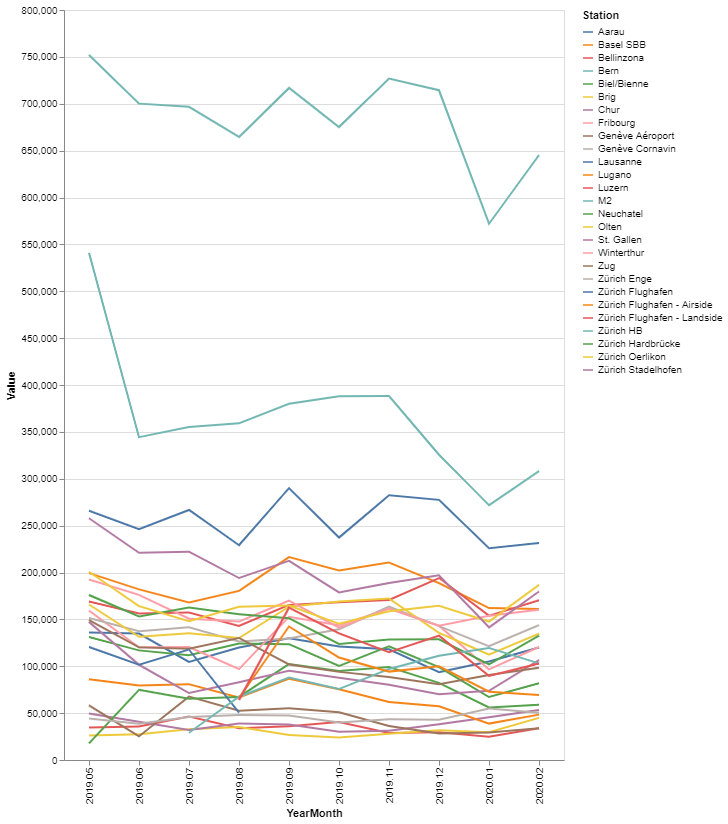

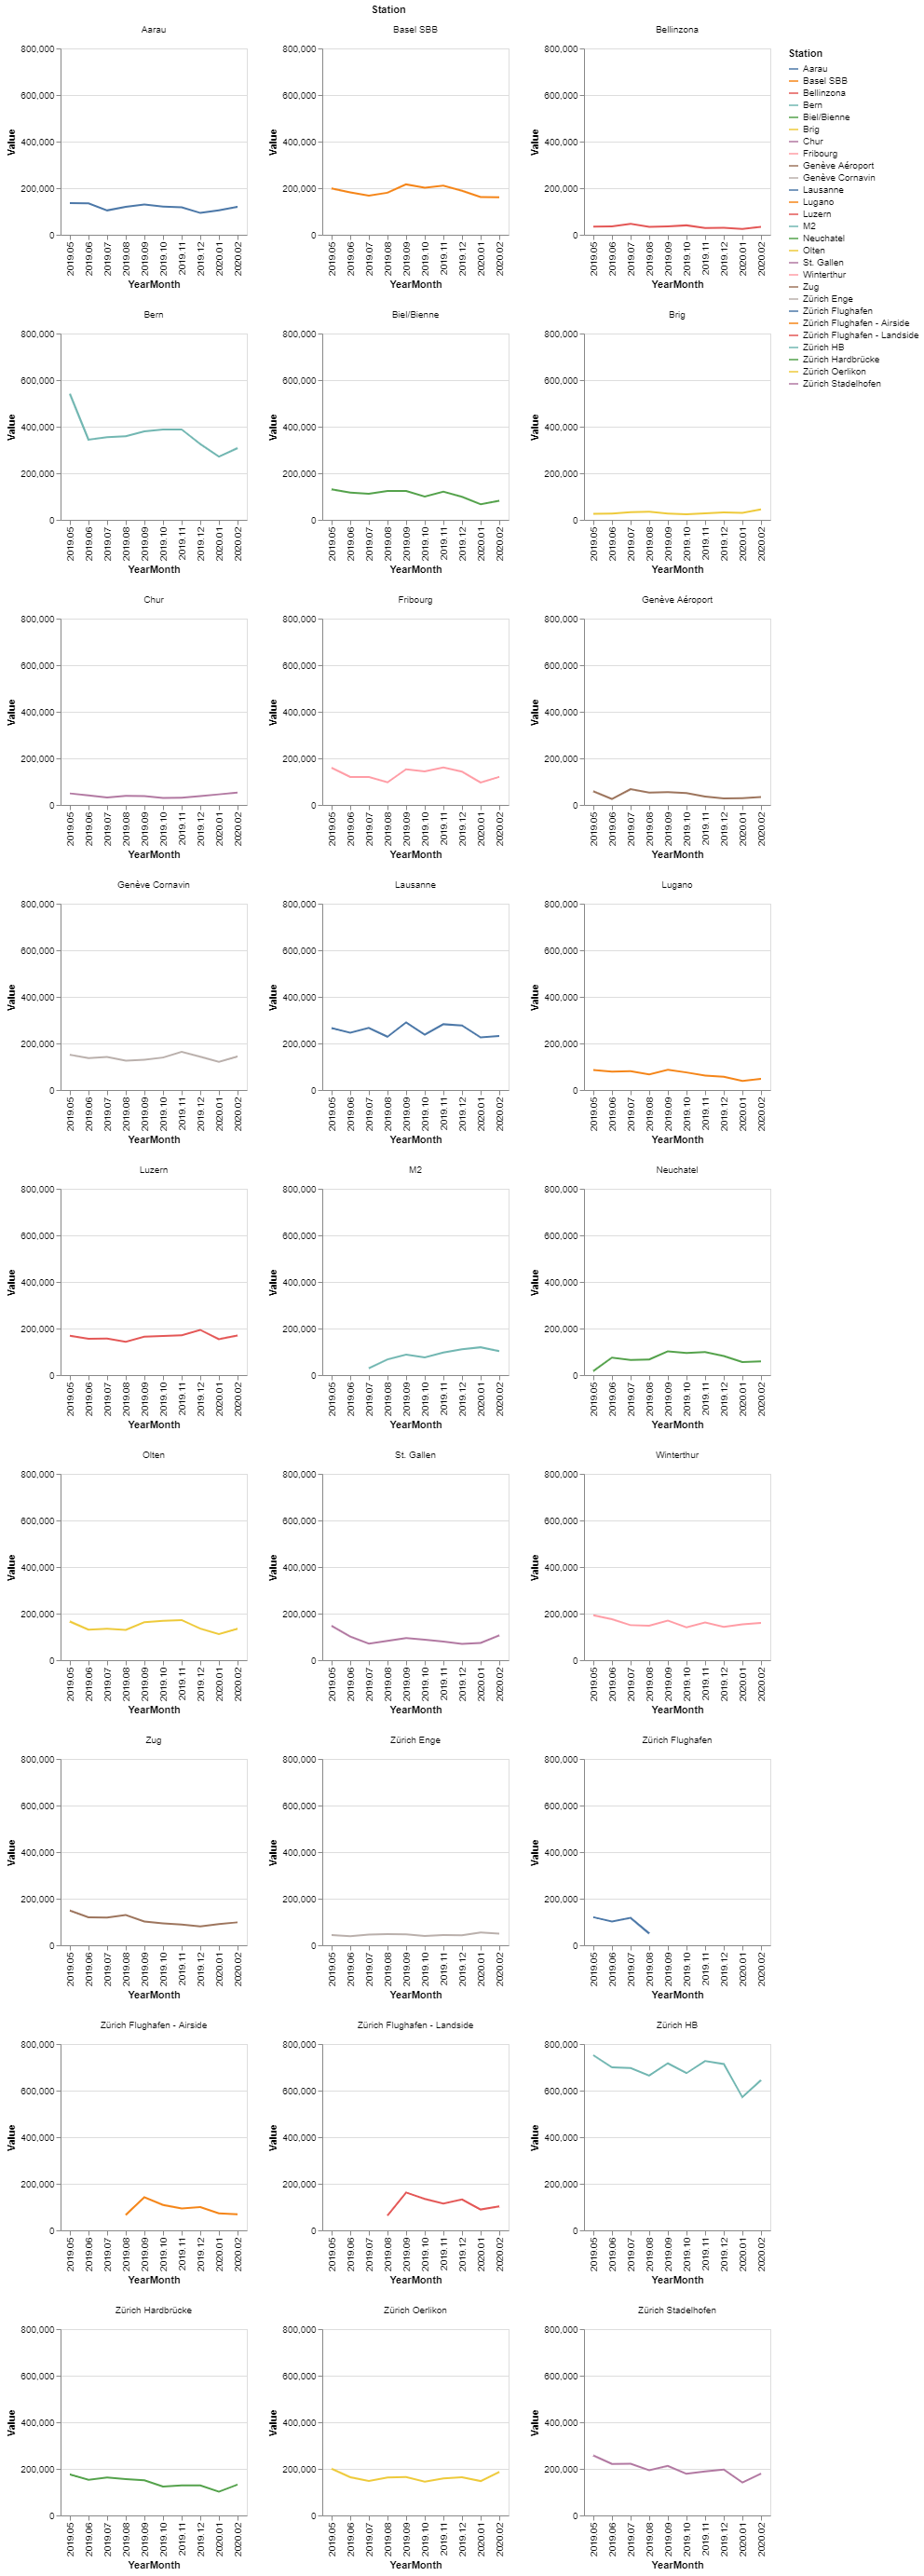

In [35]:
chart_data = ax_months.copy()

month_chart = alt.Chart(chart_data).mark_line().encode(
    x="YearMonth:O",
    y="Value:Q",
    color="Station",
    tooltip=["Station", 'YearMonth', 'Value']
)
single_chart = month_chart.properties(width=500, height=750)
facets = (month_chart
          .encode(facet=alt.Facet("Station:N"))
          .properties(width=200, height=200, columns=3)
          .resolve_axis(y="independent", x="independent")
         )

single_chart.display()
facets.display()